## Train an RL agent interacting with a stable grid
This notebook will focus the following topics:

 - define an experiment using classic controllers and RL agents,
 - how to use the names of a named policy to hand different rewards to different agents,
 - learn how the `MultiController hands the correct indices to the corresponding controllers,
 - training an RL agent for a task in an electric grid formed by a classic controller.

In this notebook a reinforcement learning agent is trained to draw current from a stable grid.
The 3-phase electric power grid is formed by a classic controller in open-loop (`Swing`) mode. 
For more details about how the classic control works, see `Classical_Controllers_Introduction.ipynb`.

The use case is shown in the figure below.
This environment consists of a 3-phase electrical power grid with 2 sources connected via a cable.

![](figures/RL_classic_swing.png "")

The first source is controlled by the RL agent `my_ddpg` which should learn to draw power from the grid, therefore act like an active load.
The secound source is controlled by a classic controller in open-loop. 
The Swing mode is used to create a stable 3-phase grid to supply the load.



In [1]:
using JEG
using ReinforcementLearning

In [2]:
parameters = 
Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}(
                        "pwr" => 200e3, 
                        "control_type" => "RL", 
                        "mode" => "my_ddpg", 
                        "fltr" => "L"),
                    Dict{Any, Any}(
                        "pwr" => 200e3, 
                        "fltr" => "LC", 
                        "control_type" => 
                        "classic", "mode" => 1),
                    ],
    "grid" => Dict{Any, Any}(
        "phase" => 3, 
        "ramp_end" => 0.04,)
)

Dict{Any, Any} with 2 entries:
  "source" => Any[Dict{Any, Any}("control_type"=>"RL", "mode"=>"my_ddpg", "fltr…
  "grid"   => Dict{Any, Any}("phase"=>3, "ramp_end"=>0.04)

Like already introduced in `RL_Single_Agent_DEMO.ipynb`, an appropriate `reference(t)` function has to be defined to communicate the wanted task to learn to the agent.
In this example we will use the time `t` handed over to the function to generate time-variing reference signals.
In more detail a three-phase sinusoidal refrence signal shifted by 120° and an aplitude of 10 A is created.
This should teach the agent to draw time-variing current from the grid. 
The phase is thereby chosen similar to the definition in the `Swing` mode.

$i_\mathrm{L,ref} =  - 10 \,\text{cos}\left(2 \pi \,50 \, t - \frac{2}{3} \pi (n-1) \right)$, with $n \in [0,1,2]$.

Here, n represents the index refering to the 3 phases of the grid.

For more enhanced reference functions, the reference current could be chosen with regards to power (active and reactive) reference values.
Feel free to implement, change and contribute! 

In [3]:
function reference(t)
    θ = 2*pi*50*t
    θph = [θ; θ - 120π/180; θ + 120π/180]
    return -10 * cos.(θph) 
end

reference (generic function with 1 method)

Afterwards the `featurize()` function adds the signal generated by the `reference` function to the state for the agent `my_ddpg`:

In [4]:
featurize_ddpg = function(state, env, name)
    if name == "my_ddpg"
        norm_ref = env.nc.parameters["source"][1]["i_limit"]
        state = vcat(state, reference(env.t)/norm_ref)
    end
end

#9 (generic function with 1 method)

Then the `reward()` function is defined. Here, again it is based on the root-mean square error (RMSE) teach the agent `my_ddpg` to match the reference signal to the measured signal. 

If the measured state is greater than `1`. In that case a punishment is returned which, here, is chosen to be `r = -1`.
It not and if the measured value differs from the reference, the average error is substracted from the maximal reward: `r = 1 - RMSE`:

$r = 1 - \frac{1}{3} \sum_{{p \in \{\mathrm{a,b,c}\}}} \sqrt{\frac{|i_\mathrm{L,ref,p} - i_\mathrm{L1,p}|}{2}}$

This function is only used if the name of the policy is `my_ddpg` which was chosen in the parameter dict. 
In any other case, 1 is returned.
This could be used to define 2 different reward functions for 2 different agents via name (e.g., `my_ddpg` and `my_sac`) to learn for example a current control with the `my_ddpg` agent but a voltage control task with the `my_sac` agent.

Here, in any case but `name == my_ddpg` - so in case of the `classic` controller `r = 1` is returned.

In [5]:
function reward_function(env, name = nothing)
    if name == "my_ddpg"
        state_to_control_1 = env.state[findfirst(x -> x == "source1_i_L1_a", env.state_ids)]
        state_to_control_2 = env.state[findfirst(x -> x == "source1_i_L1_b", env.state_ids)]
        state_to_control_3 = env.state[findfirst(x -> x == "source1_i_L1_c", env.state_ids)]

        state_to_control = [state_to_control_1, state_to_control_2, state_to_control_3]

        if any(abs.(state_to_control).>1)
            return -1
        else

            refs = reference(env.t)
            norm_ref = env.nc.parameters["source"][1]["i_limit"]          
            r = 1-1/3*(sum((abs.(refs/norm_ref - state_to_control)/2).^0.5))
            return r 
        end
    else
        return 1
    end

end

reward_function (generic function with 2 methods)

Then, the defined parameters, featurize and reward functions are used to create an environment consisting of the electircal power grid. Here, no CM Matrix defining the connection is used. Since the grid consists only of 2 sources there is only connection possible. The `ElectricGridEnv` creates this internally based on the length of the parameter dict sources.

In [6]:
env = ElectricGridEnv(
    parameters = parameters, 
    t_end = 0.1, 
    featurize = featurize_ddpg, 
    reward_function = reward_function, 
    action_delay = 0);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



Like already shon in `RL_Single_Agent_DEMO.ipynb`, again an DDPG agent is created. 
The `SetupAgents()` function is then used to configure the `controllers` utilizing the `MultiController`.

In [7]:
agent = CreateAgentDdpg(na = length(env.agent_dict["my_ddpg"]["action_ids"]),
                          ns = length(state(env, "my_ddpg")),
                          use_gpu = false)

my_custom_agents = Dict("my_ddpg" => agent)

controllers = SetupAgents(env, my_custom_agents)

typename(MultiController)
├─ agents => typename(Dict)
├─ action_ids => 6-element Vector{String}
└─ hook => typename(DataHook)
   ├─ save_data_to_hd => false
   ├─ dir => "episode_data/"
   ├─ A => typename(Nothing)
   ├─ B => typename(Nothing)
   ├─ collect_state_paras => typename(Nothing)
   ├─ extra_state_paras => 0-element Vector{Any}
   ├─ extra_state_ids => 0-element Vector{Any}
   ├─ extra_state_names => 0-element Vector{Any}
   ├─ collect_sources => 0-element Vector{Any}
   ├─ collect_cables => 0-element Vector{Any}
   ├─ collect_loads => 0-element Vector{Any}
   ├─ collect_state_ids => 0-element Vector{Any}
   ├─ collect_next_state_ids => 0-element Vector{Any}
   ├─ collect_action_ids => 0-element Vector{Any}
   ├─ df => typename(DataFrames.DataFrame)
   │  ├─ columns => 0-element Vector{AbstractVector}
   │  └─ colindex => typename(DataFrames.Index)
   │     ├─ lookup => typename(Dict)
   │     └─ names => 0-element Vector{Symbol}
   ├─ tmp => typename(DataFrames.DataFrame)
  

Like shown in the following figure, the `controllers` struct constits now of 2 agents - one per source.

![](figures/Multiagent_classic_RL.png "")

Since we have defined 2 sources in the env, one controller classically and the other by RL, the `MultiController` hands over the correct indices of the environment to the controllers:


In [8]:
controllers.agents

Dict{Any, Any} with 2 entries:
  "classic" => Dict{Any, Any}("policy"=>typename(NamedPolicy)…
  "my_ddpg" => Dict{Any, Any}("policy"=>typename(Agent)…

This enables each controller, e.g., to find the correct states in the environment state.
In the parameter dict the first source is labeled to be controlled by the RL agent: 

In [9]:
controllers.agents["my_ddpg"]

Dict{Any, Any} with 3 entries:
  "policy"     => typename(Agent)…
  "action_ids" => ["source1_u_a", "source1_u_b", "source1_u_c"]
  "state_ids"  => ["source1_i_L1_a", "source1_v_C_cables_a", "source1_i_L1_b", …

The secound source is controlled via the classic controller: 

In [10]:
controllers.agents["classic"]

Dict{Any, Any} with 3 entries:
  "policy"     => typename(NamedPolicy)…
  "action_ids" => ["source2_u_a", "source2_u_b", "source2_u_c"]
  "state_ids"  => ["source2_i_L1_a", "source2_v_C_filt_a", "source2_v_C_cables_…

Then the `Learn()` function is used to train 20 episodes. 
Here only the RL agent is trained. 
The classic controller is executed to control the secound source.

In [11]:
Learn(controllers, env, num_episodes = 20)

Progress:  10%|████▏                                    |  ETA: 0:07:12

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


                 ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀        
                 ┌────────────────────────────────────────┐        
             369 │⠀⠀⠀⡸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ classic
                 │⠀⠀⢰⠁⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ my_ddpg
                 │⠀⠀⠇⠀⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⡠⡆⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠎⠀⢣⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
   Score         │⠀⠀⠀⠀⠸⣸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⡟⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⢸⠀⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⠈⢆⠀⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⠀⠈⢆⠘⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⠀⠀⠀⢇⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

DataHook(false, "episode_data/", [-199.99999999999997 -2927.9783900064085 … 0.0 0.0; 5000.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … -29051.50877647147 5000.0; 0.0 0.0 … -4000.0 -832.0], [2927.9783900064085 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Any[0.0003415325753131024, 0.0002, 0.0003415325753131024, 0.00015412304086843381, 0.0002, 0.00025, 0.0003415325753131024, 0.0002, 0.0003415325753131024, 0.00015412304086843381, 0.0002, 0.00025, 0.0003415325753131024, 0.0002, 0.0003415325753131024, 0.00015412304086843381, 0.0002, 0.00025], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], 1396×5 DataFrame
  Row │ episode  time     action                             reward  done  
      │ Int64    Float32  Array…                             Int64   Bool  
──────┼────────────────────────────────────────────────────────────────────
    1 │       1   0.0     Union{Nothing, Float64}[-0.00721…       1  false
    2 │       1   0.0001  Union{Nothing, Float64}[-0.06

In the output the two different rewards for `classic` and `my_ddpg` can be identified.
Shown is the accumulated reward per episode. Since the `classic` gets `r = 1` per step, this reward correlates with the length of the episode while the reward for the `my_ddpg` agent is depending on the above described reward function.
After the training, the `Simulate()` function is used to run a test epiode without action noise and the state to be controlled ($i_\mathrm{L1}$) is plotted:

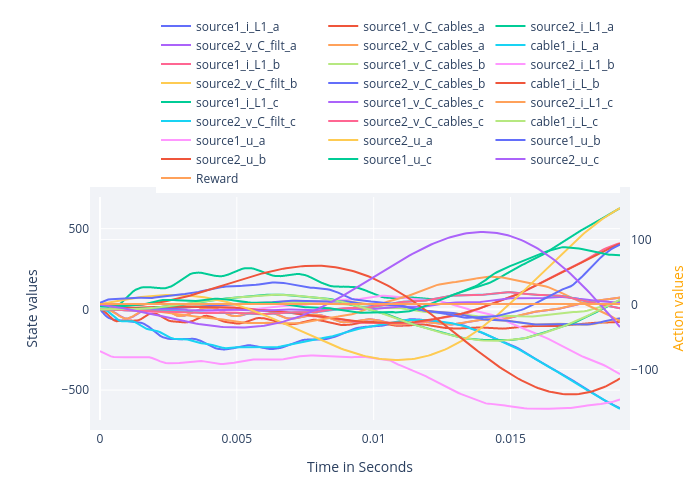

In [12]:
hook = DataHook(collect_state_ids = env.state_ids,
                collect_action_ids = env.action_ids)

hook = Simulate(controllers, env, hook=hook)


RenderHookResults(hook = hook,
                    states_to_plot  = env.state_ids,
                    actions_to_plot = env.action_ids,
                    plot_reward=true)
